# ATS Scoring Dataset Analysis
## Applicant Tracking System Score Prediction

This notebook analyzes the ATS dataset to understand:
- How CVs are scored by Applicant Tracking Systems
- Key features that contribute to ATS scores
- Patterns in high-scoring vs. low-scoring CVs
- Building models to predict ATS compatibility scores

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load the Dataset

In [7]:
# Load training and validation data
data_path = Path('../data/ats')
train_df = pd.read_csv(data_path / 'train.csv')
val_df = pd.read_csv(data_path / 'validation.csv')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"\nTraining data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")

Training samples: 5099
Validation samples: 1275

Training data shape: (5099, 3)
Validation data shape: (1275, 3)


In [8]:
# Load metadata if available
metadata_file = data_path / 'dataset_metadata.json'
if metadata_file.exists():
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    print("\nDataset Metadata:")
    print(json.dumps(metadata, indent=2))


Dataset Metadata:
{
  "dataset_name": "resume-ats-score-v1-en",
  "version": "1.0.0",
  "description": "Semantic similarity training dataset for fine-tuning sentence transformers to predict ATS (Applicant Tracking System) compatibility scores between resumes and job descriptions",
  "total_examples": 6374,
  "train_examples": 5099,
  "validation_examples": 1275,
  "task": "sentence_similarity",
  "format": "text_pairs_with_scores",
  "input_format": "resume [SEP] job_description",
  "score_range": {
    "min": 18.28,
    "max": 90.68,
    "mean": 47.19,
    "median": 29.9
  },
  "label_categories": {
    "No Fit": "ATS score < 40 (poor match)",
    "Potential Fit": "ATS score 40-70 (moderate match)",
    "Good Fit": "ATS score > 70 (strong match)"
  },
  "label_distribution": {
    "No Fit": 3457,
    "Potential Fit": 1716,
    "Good Fit": 1692
  },
  "training_objective": "CosineSimilarityLoss for learning semantic alignment between resumes and job requirements",
  "use_case": "Fine-

## 2. Explore Dataset Structure

In [9]:
# Display first few rows
print("Training Data Sample:")
display(train_df.head())

print("\nColumn Names:")
print(train_df.columns.tolist())

print("\nData Types:")
print(train_df.dtypes)

print("\nMissing Values:")
missing_df = pd.DataFrame({
    'Column': train_df.columns,
    'Missing Count': train_df.isnull().sum(),
    'Missing %': (train_df.isnull().sum() / len(train_df) * 100).round(2)
})
display(missing_df[missing_df['Missing Count'] > 0])

Training Data Sample:


,text,ats_score,original_label
0,SummaryI am seeking a position wherein I may u...,80.6,Good Fit
1,ProfileHighly motivated Sales Associate with e...,24.3,No Fit
2,SummaryHaving achieved a milestone of 7 years ...,53.9,Potential Fit
3,SummaryWireless communications engineer with e...,52.5,Potential Fit
4,SummaryData Entry experienced and adept at inp...,59.2,Potential Fit



Column Names:
['text', 'ats_score', 'original_label']

Data Types:
text               object
ats_score         float64
original_label     object
dtype: object

Missing Values:


,Column,Missing Count,Missing %


In [10]:
# Basic statistics
print("Dataset Statistics:")
display(train_df.describe(include='all'))

Dataset Statistics:


,text,ats_score,original_label
count,5099,5099.000000,5099
unique,5099,NaN,3
top,Career OverviewMeticulous Senior Software Test...,NaN,No Fit
freq,1,NaN,2565
mean,NaN,47.187452,NaN
std,NaN,24.970249,NaN
min,NaN,19.160000,NaN
25%,NaN,24.700000,NaN
50%,NaN,29.900000,NaN
75%,NaN,59.800000,NaN


## 3. ATS Score Distribution Analysis

Score column: ats_score

Score statistics:
count    5099.000000
mean       47.187452
std        24.970249
min        19.160000
25%        24.700000
50%        29.900000
75%        59.800000
max        90.050000
Name: ats_score, dtype: float64


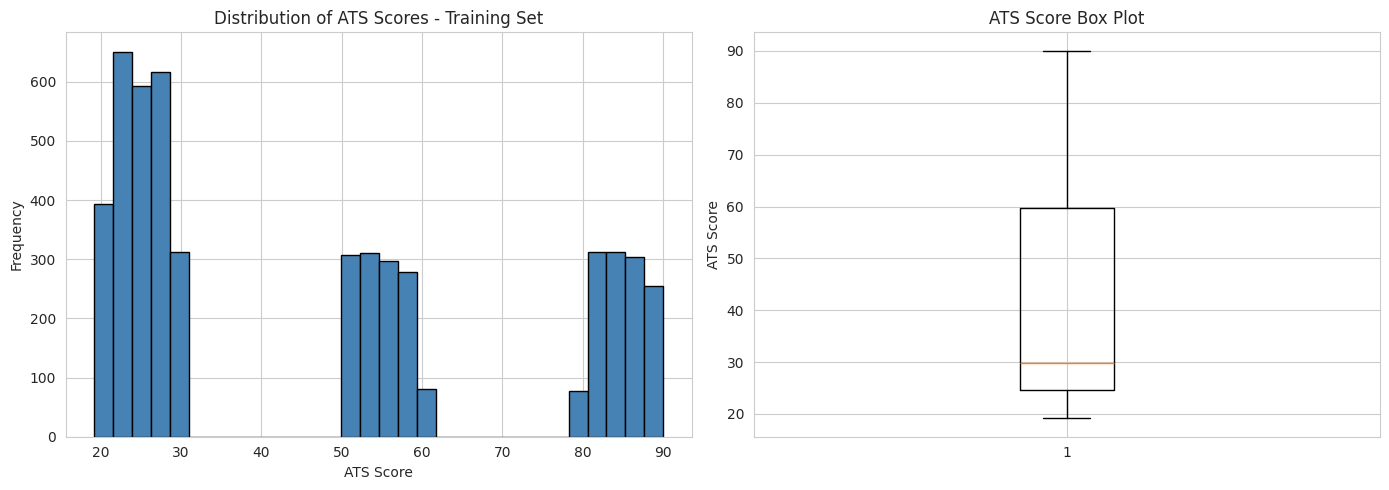

In [11]:
# Identify the score column
score_cols = [col for col in train_df.columns if 'score' in col.lower() or 'rating' in col.lower()]
if not score_cols and 'label' in train_df.columns:
    score_cols = ['label']
elif not score_cols:
    score_cols = [train_df.columns[-1]]  # Assume last column is target

score_col = score_cols[0]
print(f"Score column: {score_col}")
print(f"\nScore statistics:")
print(train_df[score_col].describe())

# Visualize score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df[score_col].dropna(), bins=30, color='steelblue', edgecolor='black')
axes[0].set_title(f'Distribution of ATS Scores - Training Set')
axes[0].set_xlabel('ATS Score')
axes[0].set_ylabel('Frequency')

# Box plot
axes[1].boxplot(train_df[score_col].dropna(), vert=True)
axes[1].set_title('ATS Score Box Plot')
axes[1].set_ylabel('ATS Score')

plt.tight_layout()
plt.show()

## 4. Feature Analysis

In [12]:
# Analyze text features
text_columns = [col for col in train_df.columns if train_df[col].dtype == 'object']

print(f"Text columns: {text_columns}")

# Add length features
for col in text_columns:
    train_df[f'{col}_length'] = train_df[col].astype(str).apply(len)
    train_df[f'{col}_word_count'] = train_df[col].astype(str).apply(lambda x: len(x.split()))
    
    print(f"\n{col}:")
    print(f"  Avg length: {train_df[f'{col}_length'].mean():.2f} characters")
    print(f"  Avg words: {train_df[f'{col}_word_count'].mean():.2f} words")

Text columns: ['text', 'original_label']

text:
  Avg length: 8477.74 characters
  Avg words: 1099.39 words

original_label:
  Avg length: 8.24 characters
  Avg words: 2.00 words


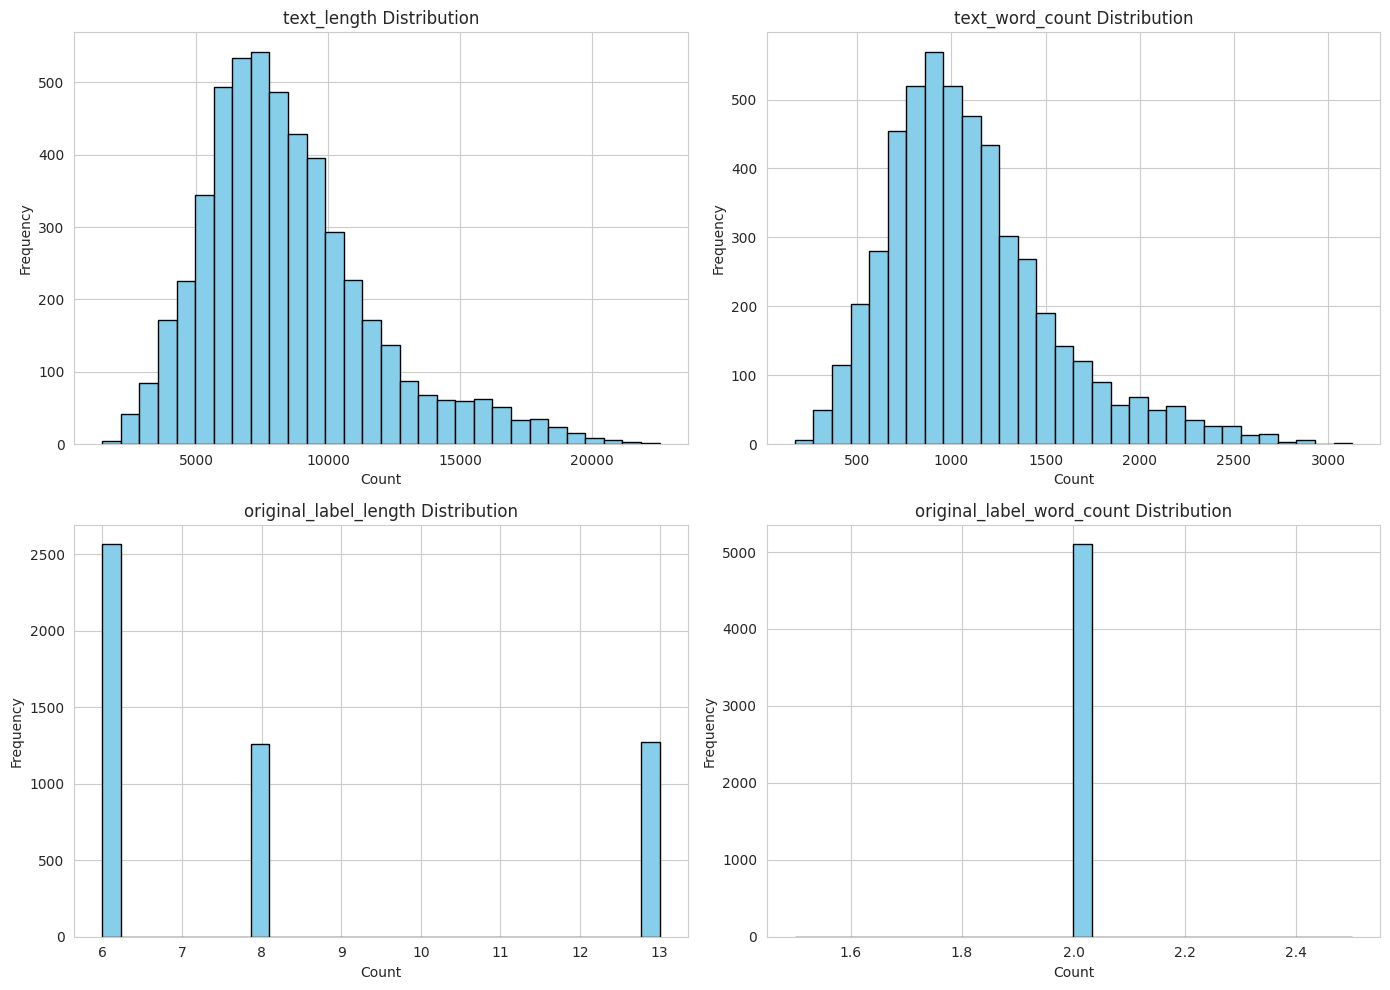

In [13]:
# Visualize text length distributions
length_cols = [col for col in train_df.columns if '_length' in col or '_word_count' in col]

if len(length_cols) > 0:
    n_cols = min(2, len(length_cols))
    n_rows = (len(length_cols) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
    axes = axes.flatten() if len(length_cols) > 1 else [axes]
    
    for idx, col in enumerate(length_cols):
        axes[idx].hist(train_df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'{col} Distribution')
        axes[idx].set_xlabel('Count')
        axes[idx].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## 5. Correlation with ATS Score

Correlation with ATS Score:

ats_score                    1.000000
original_label_length        0.447807
text_word_count              0.006843
text_length                  0.004349
original_label_word_count         NaN
Name: ats_score, dtype: float64


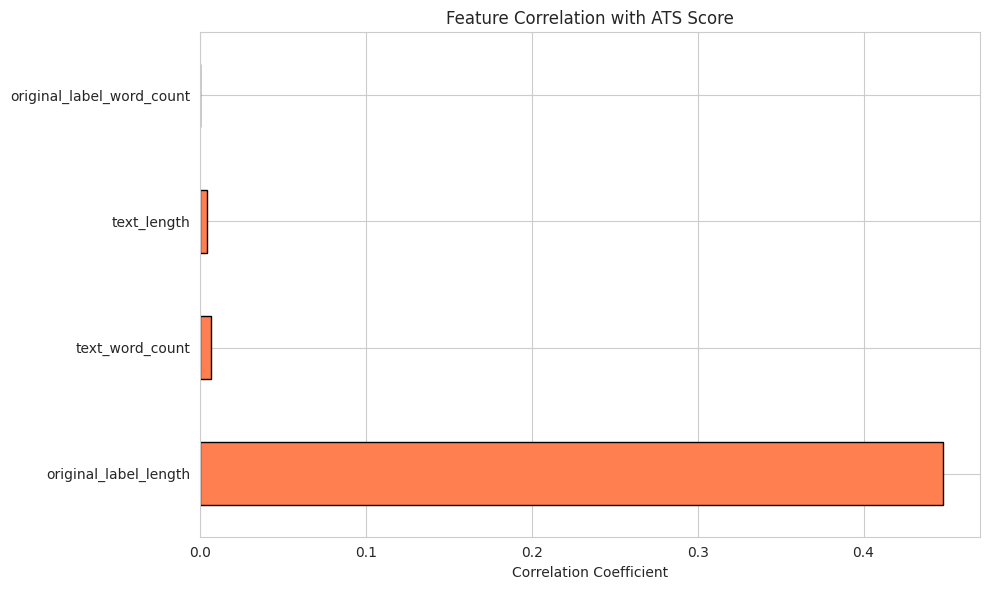

In [14]:
# Analyze correlation between features and ATS score
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

if score_col in numeric_cols and len(numeric_cols) > 1:
    # Correlation with score
    correlations = train_df[numeric_cols].corr()[score_col].sort_values(ascending=False)
    print("Correlation with ATS Score:\n")
    print(correlations)
    
    # Visualize correlations
    plt.figure(figsize=(10, 6))
    correlations.drop(score_col).plot(kind='barh', color='coral', edgecolor='black')
    plt.title('Feature Correlation with ATS Score')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()

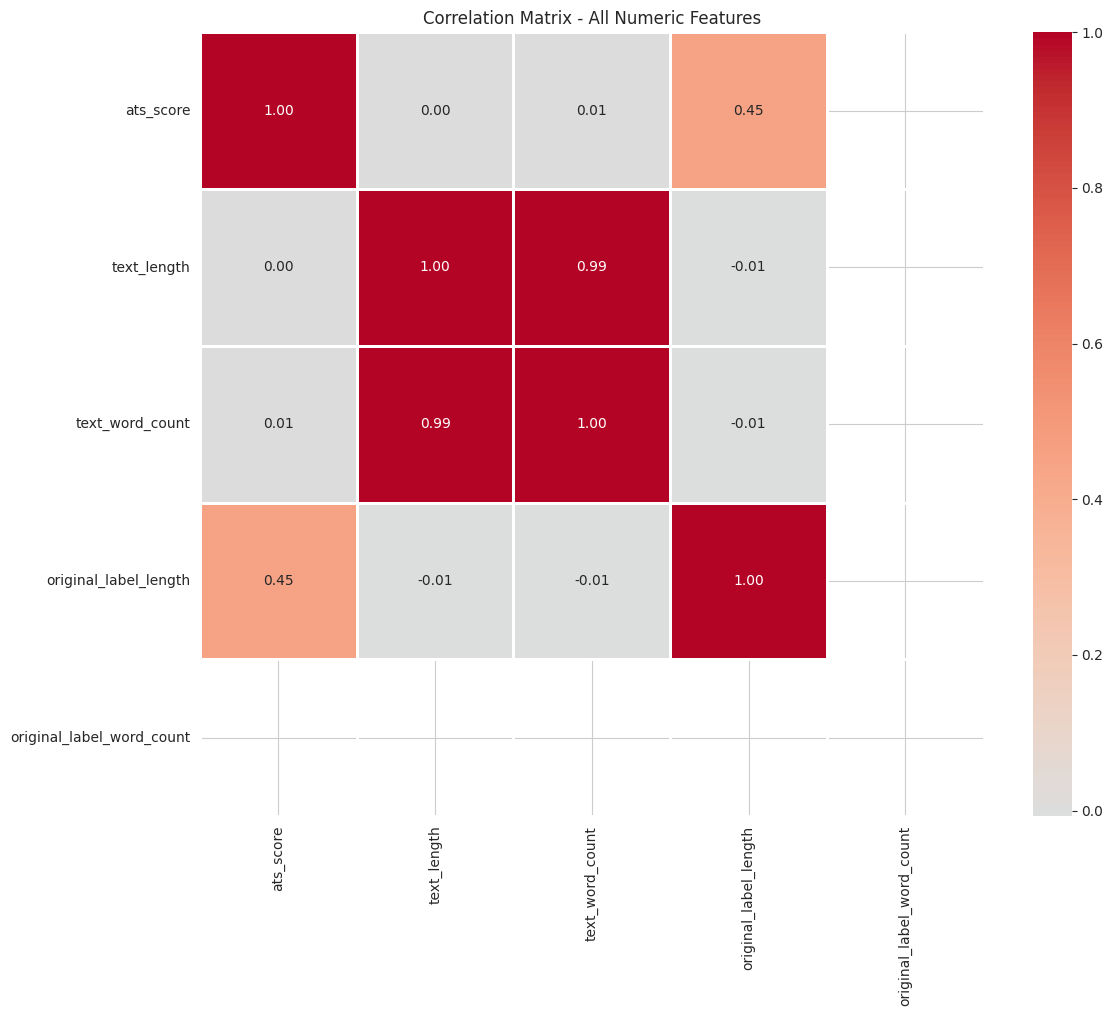

In [15]:
# Full correlation matrix
if len(numeric_cols) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = train_df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=1, fmt='.2f')
    plt.title('Correlation Matrix - All Numeric Features')
    plt.tight_layout()
    plt.show()

## 6. Score Category Analysis

Score Category Distribution:
score_category
Low       2565
Medium    1273
High      1261
Name: count, dtype: int64


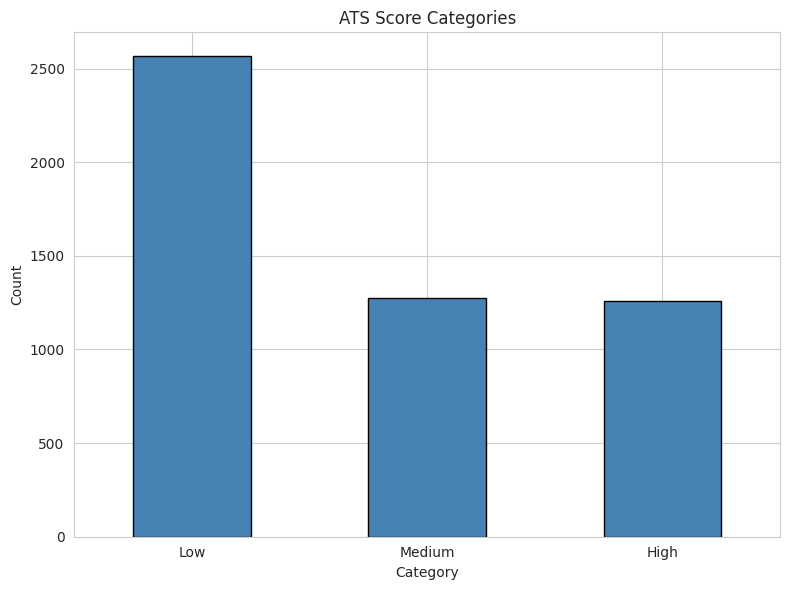

In [16]:
# Create score categories
if train_df[score_col].dtype in [np.float64, np.int64]:
    # If numeric, create bins
    train_df['score_category'] = pd.cut(train_df[score_col], 
                                         bins=3, 
                                         labels=['Low', 'Medium', 'High'])
    
    print("Score Category Distribution:")
    print(train_df['score_category'].value_counts())
    
    # Visualize
    plt.figure(figsize=(8, 6))
    train_df['score_category'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title('ATS Score Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 7. Text Content Analysis

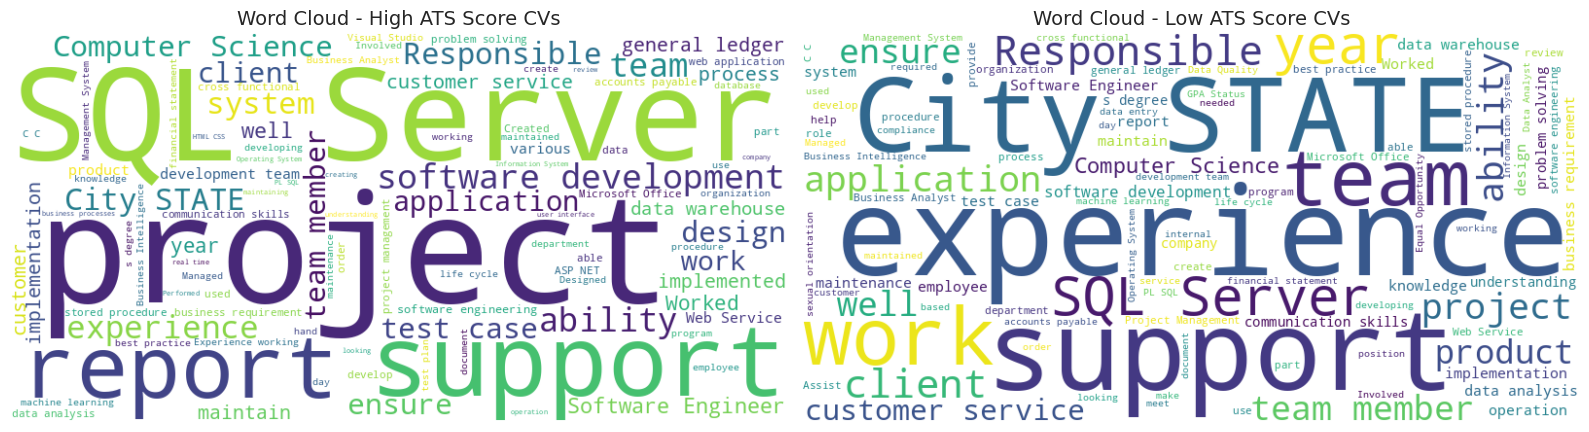

In [17]:
# Generate word clouds for high vs. low scoring CVs
if len(text_columns) > 0 and 'score_category' in train_df.columns:
    text_col = text_columns[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # High scoring CVs
    high_score_text = ' '.join(train_df[train_df['score_category'] == 'High'][text_col].astype(str).values)
    if high_score_text:
        wordcloud_high = WordCloud(width=800, height=400, 
                                   background_color='white',
                                   max_words=100).generate(high_score_text)
        axes[0].imshow(wordcloud_high, interpolation='bilinear')
        axes[0].axis('off')
        axes[0].set_title('Word Cloud - High ATS Score CVs', fontsize=14)
    
    # Low scoring CVs
    low_score_text = ' '.join(train_df[train_df['score_category'] == 'Low'][text_col].astype(str).values)
    if low_score_text:
        wordcloud_low = WordCloud(width=800, height=400, 
                                  background_color='white',
                                  max_words=100).generate(low_score_text)
        axes[1].imshow(wordcloud_low, interpolation='bilinear')
        axes[1].axis('off')
        axes[1].set_title('Word Cloud - Low ATS Score CVs', fontsize=14)
    
    plt.tight_layout()
    plt.show()

## 8. Train vs. Validation Comparison

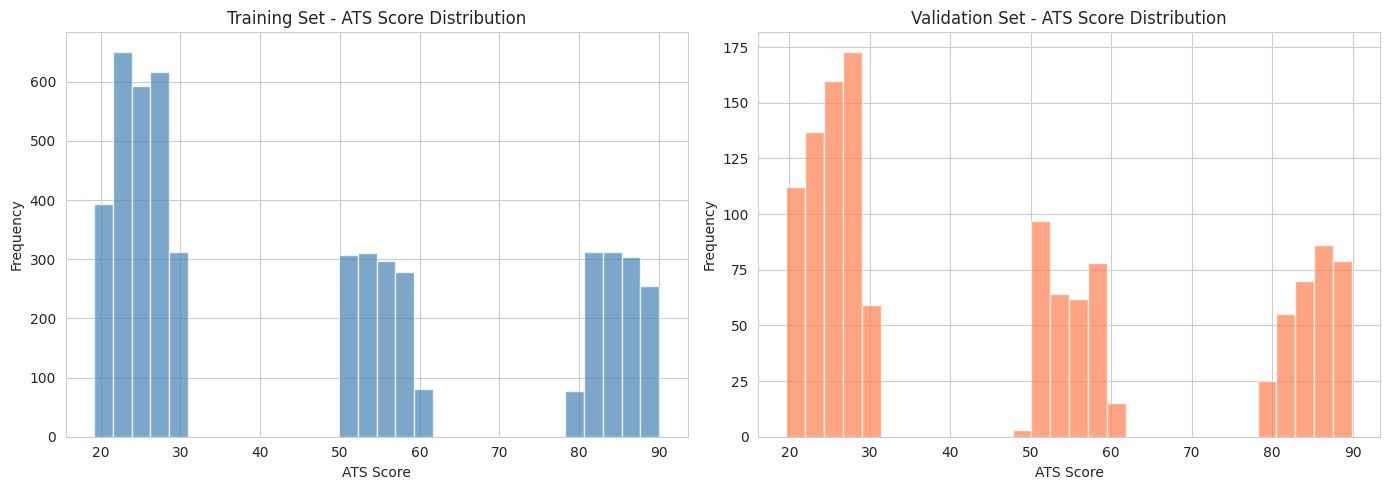


Distribution Comparison:
Train mean: 47.19
Validation mean: 47.42
Train std: 24.97
Validation std: 24.97


In [18]:
# Compare distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].hist(train_df[score_col].dropna(), bins=30, color='steelblue', alpha=0.7, label='Train')
axes[0].set_title('Training Set - ATS Score Distribution')
axes[0].set_xlabel('ATS Score')
axes[0].set_ylabel('Frequency')

# Validation set
axes[1].hist(val_df[score_col].dropna(), bins=30, color='coral', alpha=0.7, label='Validation')
axes[1].set_title('Validation Set - ATS Score Distribution')
axes[1].set_xlabel('ATS Score')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDistribution Comparison:")
print(f"Train mean: {train_df[score_col].mean():.2f}")
print(f"Validation mean: {val_df[score_col].mean():.2f}")
print(f"Train std: {train_df[score_col].std():.2f}")
print(f"Validation std: {val_df[score_col].std():.2f}")

## 9. Key Insights and Recommendations

### Findings:
- Document the score distribution and range
- Identify key features correlated with high ATS scores
- Note any data quality issues or outliers

### Recommendations for Preprocessing:
- Text normalization and cleaning
- Feature engineering (e.g., keyword matching, formatting features)
- Handling missing values
- Score normalization if needed

### Model Suggestions:
- **Regression models**: If predicting continuous ATS scores
  - BERT/RoBERTa for regression
  - LSTM with attention for sequence modeling
- **Classification models**: If categorizing scores (Low/Medium/High)
  - DistilBERT for efficient classification
  - RoBERTa for higher accuracy
- **Hybrid approach**: Combine NLP features with traditional ML (e.g., embeddings + XGBoost)
- Consider **multi-task learning**: Joint training with CV-Job matching task
- Evaluation metrics: MSE, MAE, R² (regression) or Accuracy, F1-score (classification)

## 10. Sample Examples

In [19]:
# Display sample high and low scoring examples
print("Sample High-Scoring CV:")
print("=" * 80)
high_score_sample = train_df.nlargest(1, score_col).iloc[0]
print(f"Score: {high_score_sample[score_col]}")
for col in text_columns[:2]:
    if col in high_score_sample:
        print(f"\n{col}:")
        print(str(high_score_sample[col])[:500] + "...")

print("\n" + "=" * 80)
print("Sample Low-Scoring CV:")
print("=" * 80)
low_score_sample = train_df.nsmallest(1, score_col).iloc[0]
print(f"Score: {low_score_sample[score_col]}")
for col in text_columns[:2]:
    if col in low_score_sample:
        print(f"\n{col}:")
        print(str(low_score_sample[col])[:500] + "...")

Sample High-Scoring CV:
Score: 90.05

text:
Professional SummaryObtain a position in a professional organization where I can apply my skills and loyalty in exchange for career guidance, training and opportunity for advancement., healthy snacks, casual dress codeTraining learning and development courses, speakers, team-building off-siteEmployee resource groups MPI does not discriminate on the basis of race, color, religion, sex, sexual orientation, gender identity or expression, national origin, age, disability, veteran status, marital sta...

original_label:
Good Fit...

Sample Low-Scoring CV:
Score: 19.16

text:
SummaryLogical  Data  Analyst  skilled in requirement analysis, software development and database management. Self-directed and proactive professional with 5 years of vast experience collecting, cleaning and interpreting data sets. Natural problem-solver possessing strong cross-functional understanding of information technology and business processes. SkillsQuery ToolsAnalytic